### Imports and parameters

In [1]:
from eqcorrscan.utils.clustering import cluster
from eqcorrscan import Tribe
import numpy as np
from time import time
import obspy
import csv
import math
from matplotlib import pyplot as plt #importing matplotlib for plotting
import pandas as pd
from matplotlib.gridspec import GridSpec


Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


In [2]:
#set parameters
path = '/home/smocz/expand_redpy_new_files/templates/' #path to .tgz file
filename = 'Volcano_Rainier_Network_UW_Station_RCM_Channel_HHZ.tgz' #name of .tgz file
thresh_list = [0.5,0.55,0.6]
T = Tribe().read(f'{path}{filename}') #read the .tgz file

### Looks at tgz file and groups clusters

saves to csv

In [ ]:
#pull up tgz
t3 = time()


with open(f'/home/smocz/expand_redpy_new_files/eq_clusters{thresh_list[0]}-{thresh_list[-1]}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['threshold','index','templates']) #write labels
    file.close()

stream_list = [] #list of tuples. in tuple is (stream, template id)
for t in T:
    stream_tuple = (t.st,t.name)
    stream_list.append(stream_tuple)
t4 = time()
print(f'{t4-t3} s to get stream_list')


thresh_test=[]
for thresh in thresh_list:
    t0 = time()
    print('-----')
    print(f'testing threshold of: {thresh}')

    t1 = time()
    groups = cluster(template_list=stream_list, show=False,
                      corr_thresh=thresh, shift_len=70, cores=2) #corr_thresh is cross correlation threshold, shif_len is amount
    #it can shift by, cores is how many cores to use while running
    thresh_test.append(groups)
    #groups is a list of groups, each group is a list with the templates (tuple of stream and name) in it

    t2 = time()
    print(f'{t2-t0} s to cluster {filename}')

    print('# of groups',len(groups)) #number of clusters from EQcorrscan
    print('# of templates',len(T)) #number of template
    
    ##fun output
    for gg,gr in enumerate(groups): #for each group
        thresh_label = thresh_list[thresh_test.index(groups)]
        template_list = []
        for g in gr: #for each tuple
            template_list.append(g[1])
    
        with open(f'/home/smocz/expand_redpy_new_files/eq_clusters{thresh_list[0]}-{thresh_list[-1]}.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([thresh_label,gg,' '.join(template_list)]) #write labels
            file.close()
    
    del(groups) #clear for less memory
#     break
    
print(f'{t2-t3} s to get all threshold values')




### Read csv, plot waveforms from tgz

[0.5, 0.55, 0.6]
----------------------------THRESHOLD 0.5----------------------------
num groups for 0.5 is 2
['rcmhhzrpra161']
cols: 6, rows: 1
----------------------------THRESHOLD 0.55----------------------------
num groups for 0.55 is 9
['rcmhhzrpra333']
cols: 6, rows: 2
----------------------------THRESHOLD 0.6----------------------------
num groups for 0.6 is 32
['rcmhhzrpra138']
cols: 6, rows: 6


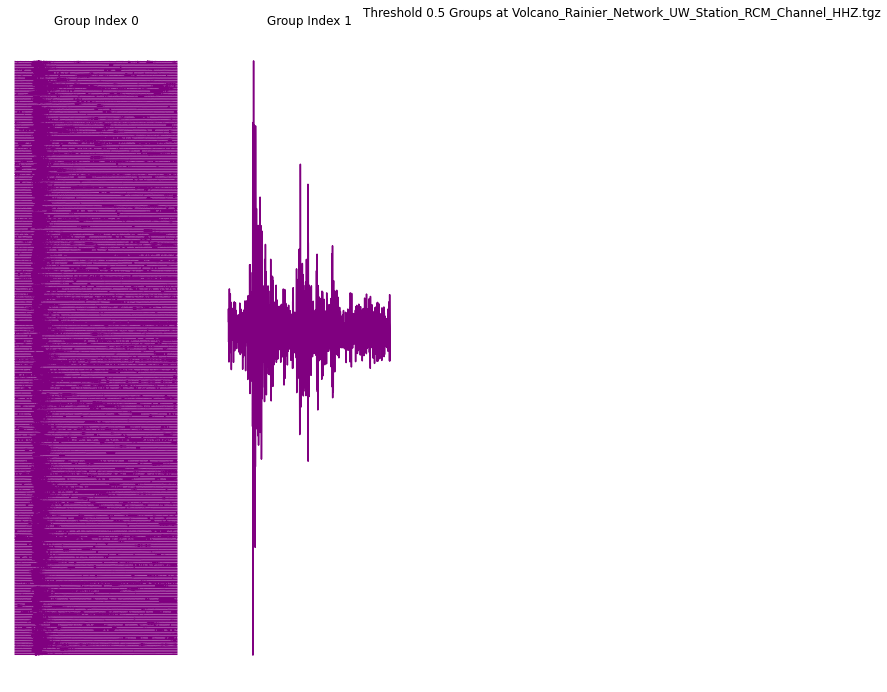

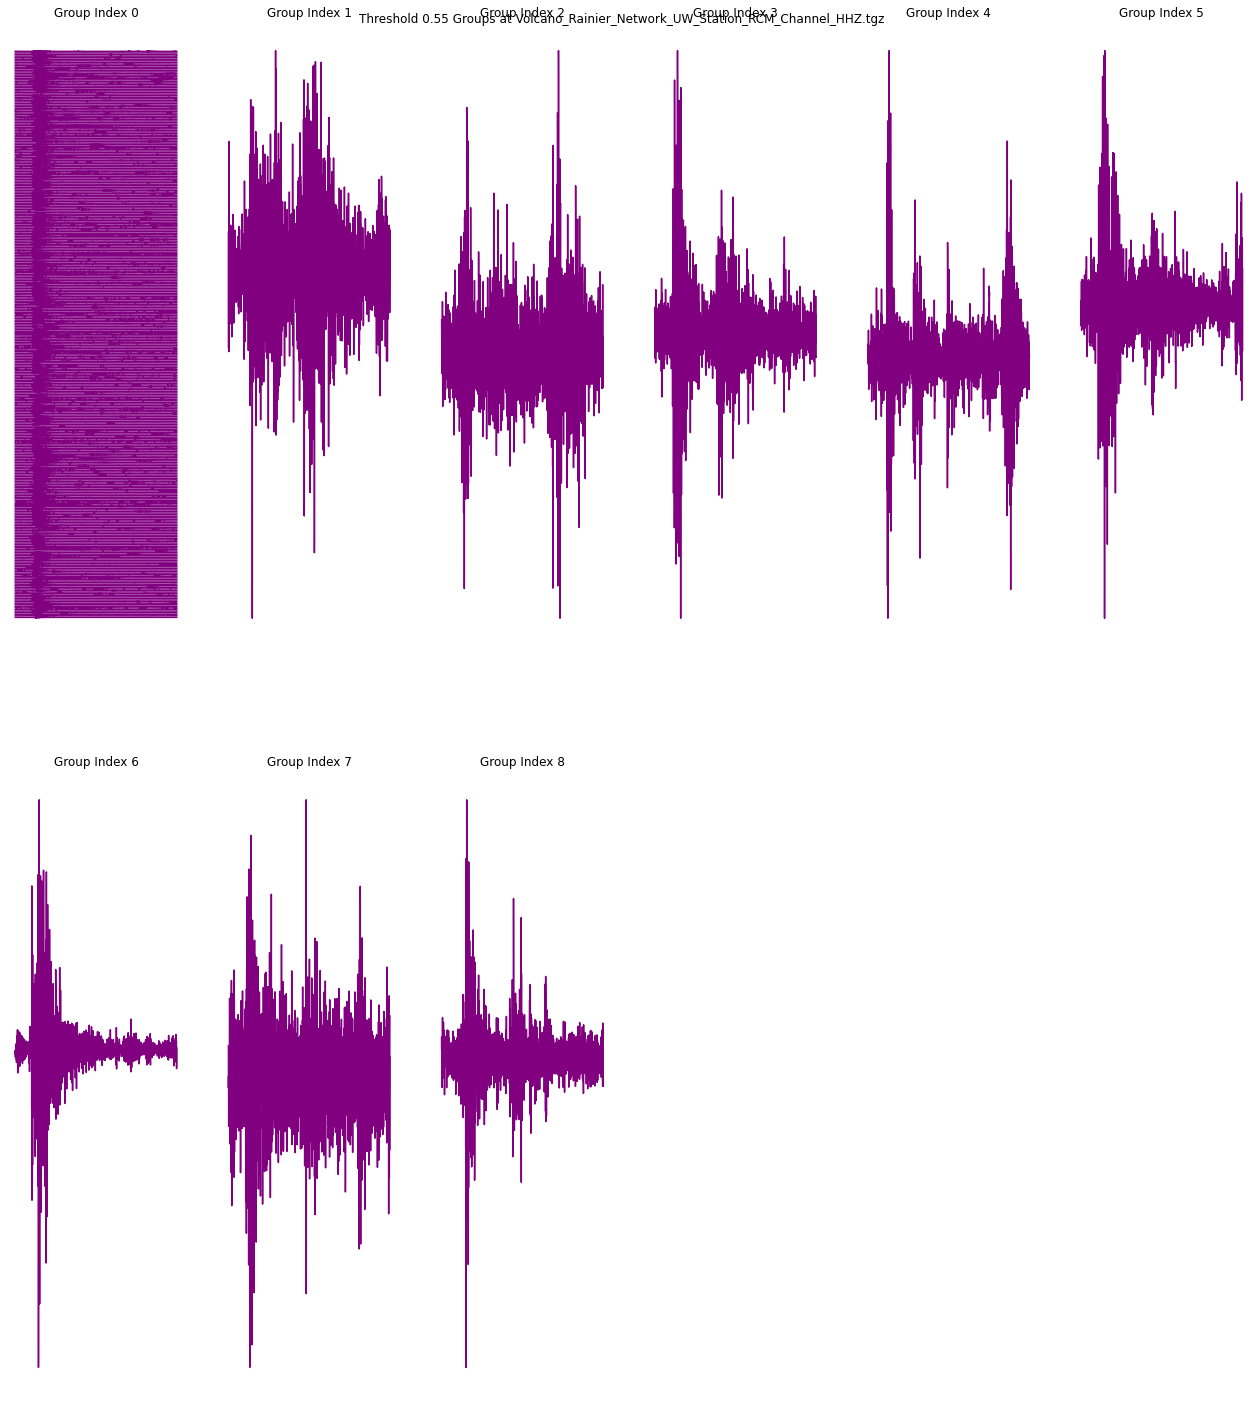

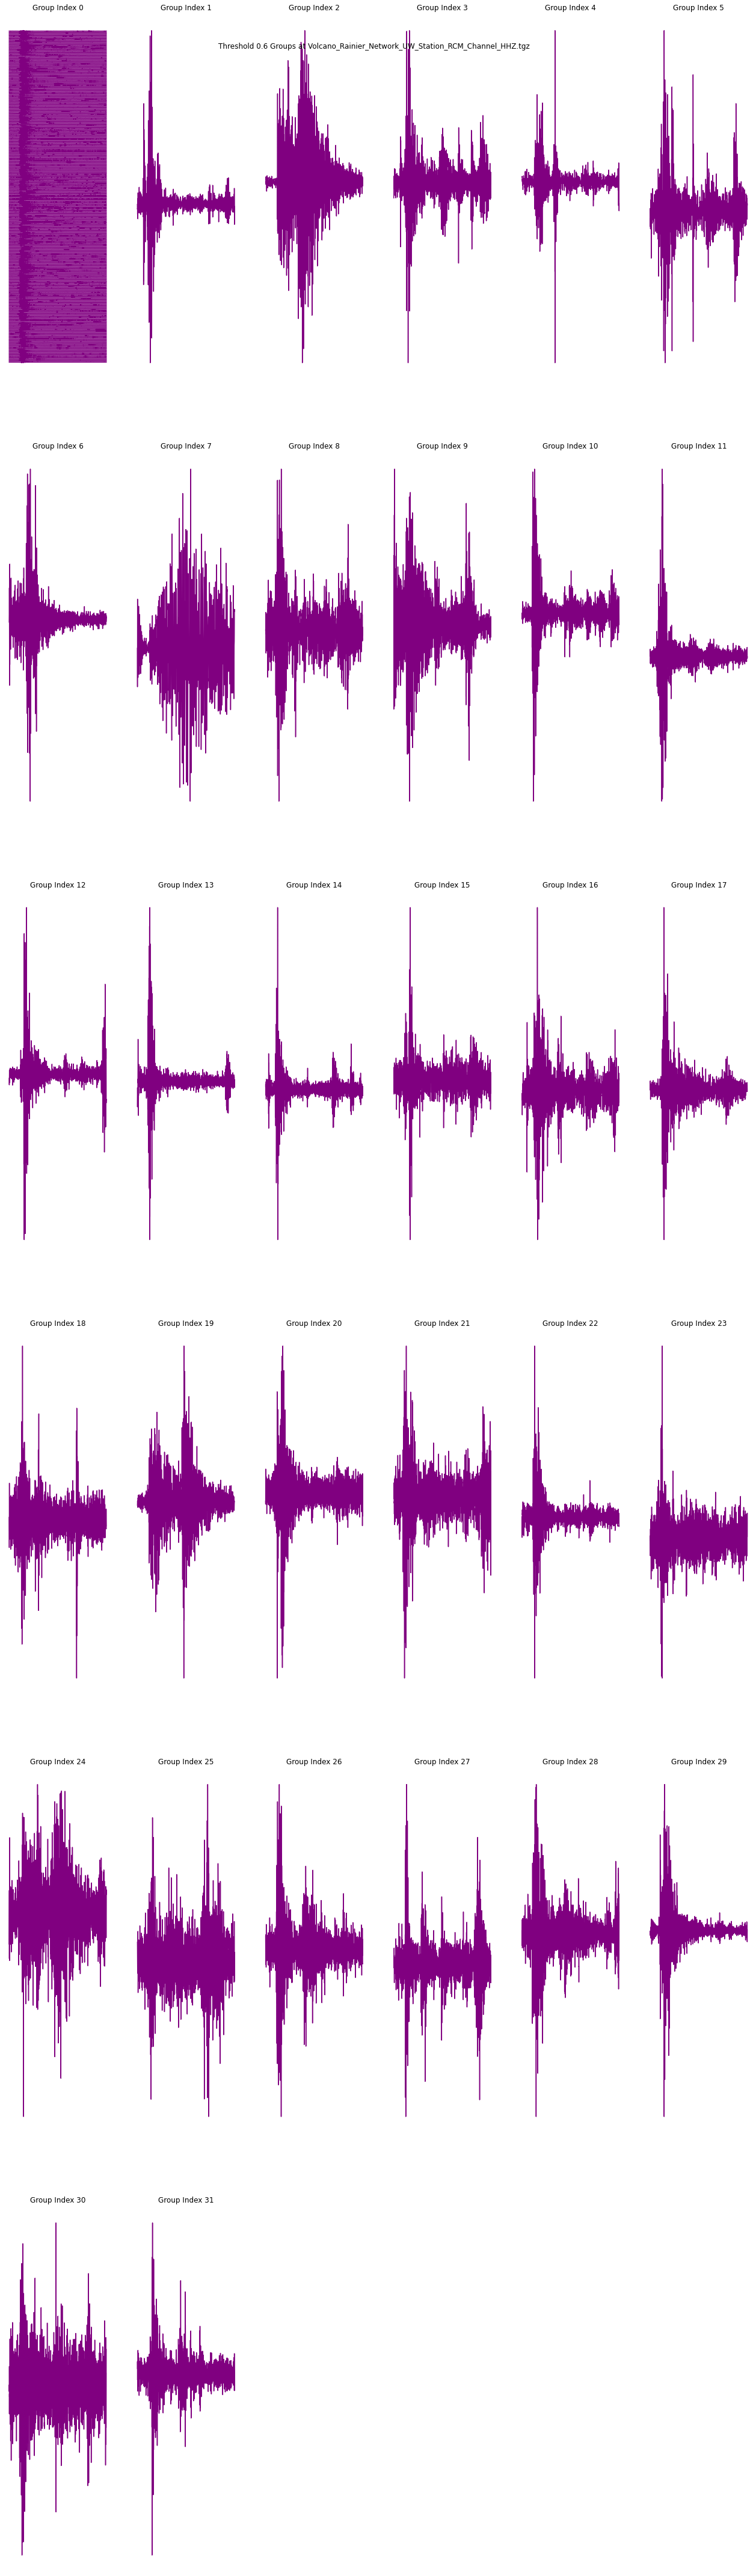

In [48]:
############### READING AND ORGANIZING CSV ###############

#read in csv
df = pd.read_csv('/home/smocz/expand_redpy_new_files/eq_clusters0.5-0.6.csv')

thresh_list = list(np.unique(df['threshold'].values.tolist())) #get list of thresholds in csv output
print(thresh_list)
num_thresh = len(thresh_list) #how many thresholds

for thresh in thresh_list:
# thresh = 0.6

    print(f'----------------------------THRESHOLD {thresh}----------------------------')
    temps = df[df['threshold']==thresh]['templates'].values.tolist() #list of templates for each threshold value
    ax_list = df[df['threshold']==thresh]['index'].values.tolist() #list of index for labels
    num_groups = len(temps) #how many templates in this threshold value
    print(f'num groups for {thresh} is {num_groups}')

    print(list(temps[1].split(' '))) #read space-separated templates as a list

    ############### PLOTTING GROUPS ###############

    #for parameterizing plot sizing
    ncols = 6 #number of columns, stays consistent
    nrows = math.ceil(num_groups/ncols) #determines number of rows needed by rounding up to nearest whole number
    print(f'cols: {ncols}, rows: {nrows}')
    fig, ax0= plt.subplots() #create subplot
    fig.set_figheight(nrows*10) #set height by nrows
    fig.set_figwidth(ncols*3) #set width by ncols
    fig.suptitle(f'Threshold {thresh} Groups at {filename}')
    plt.tight_layout() #tight layout for looking nice
    gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows


    for aa,ax_n in enumerate(ax_list):#for each subplot
    #     print(f'----{ax_n}----')
        ax = fig.add_subplot(gs[math.floor(aa/6):math.floor(aa/6)+1,aa - math.floor(aa/6)*6:aa - math.floor(aa/6)*6 +1]) #add subplot
        ax.set_title(f'Group Index {ax_n}')
        plt.axis('off') #remove axis for these plots
        temp_list = list(temps[aa].split(' ')) #turn the space-separated string into a list
    #     print(f'list: {temp_list[:2]}',end=' ') #print template names
    #     if len(temp_list) <= 2: #print an ellipse to show there are more templates without flooding output
    #         print(' ')
    #     else:
    #         print('...')
        for nn,n in enumerate(temp_list):#for each template in the associated list of templates
            for t in T: #for each template in tgz file
                if t.name == n: #if the template name matches the template we want
                    st = t.st #grab the stream
                    break #stop the search for template

            ax.plot(st[0].data[:]/np.max(np.abs(st[0].data))+2*nn,color='purple')
    #     break
    fig.delaxes(ax0) #remove unused ax

Figuring comparison between stations

I think there can be 3 outputs
1. conclusive - all (minsta?) stations have the the same grouping of clusters, everything is perfect. wow
2. inconclusive - doesn't make sense, no overlap that isn't just random
3. mostly conclusive - all (minsta?) stations SOME of the same grouping of clusters, enough that it's not random but isn't perfect


#### Now for the important part:
# How do we quantify these and process them?